# Проект: Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

### Загрузка данных

In [2]:
cars = pd.read_csv('/datasets/autos.csv')

In [3]:
cars.info()
cars.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

### Предварительный анализ

In [4]:
# функция для вывода подробой информации о данных
def analyze_dataframe(df):
    columns = df.columns
    data = []

    for col in columns:
        col_data = {
            'name': col,
            'type': str(df[col].dtype),
            'count_nan': df[col].isnull().sum(),
            'zero': (df[col] == 0).sum() if df[col].dtype in ['int64', 'float64'] else None,
            'unique': df[col].nunique(),
            'mean': df[col].mean() if df[col].dtype in ['int64', 'float64'] else None,
            'std': df[col].std() if df[col].dtype in ['int64', 'float64'] else None,
            'min': df[col].min() if df[col].dtype in ['int64', 'float64'] else None,
            'max': df[col].max() if df[col].dtype in ['int64', 'float64'] else None,
            'out_left': (df[col] < df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))).sum() if df[col].dtype in ['int64', 'float64'] else None,
            'out_right': (df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))).sum() if df[col].dtype in ['int64', 'float64'] else None
        }
        data.append(col_data)

    return pd.DataFrame(data)

In [5]:
analyze_dataframe(cars)

,name,type,count_nan,zero,unique,mean,std,min,max,out_left,out_right
0,DateCrawled,object,0,NaN,271174,NaN,NaN,NaN,NaN,NaN,NaN
1,Price,int64,0,10772.0,3731,4416.656776,4514.158514,0.0,20000.0,0.0,18979.0
2,VehicleType,object,37490,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN
3,RegistrationYear,int64,0,0.0,151,2004.234448,90.227958,1000.0,9999.0,6204.0,105.0
4,Gearbox,object,19833,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
5,Power,int64,0,40225.0,712,110.094337,189.850405,0.0,20000.0,0.0,7340.0
6,Model,object,19705,NaN,250,NaN,NaN,NaN,NaN,NaN,NaN
7,Kilometer,int64,0,0.0,13,128211.172535,37905.341530,5000.0,150000.0,53257.0,0.0
8,RegistrationMonth,int64,0,37352.0,13,5.714645,3.726421,0.0,12.0,0.0,0.0
9,FuelType,object,32895,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN


Из предоставленных данных видно следующее:

1. Наличие пропущенных значений:
   - В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` присутствуют пропущенные значения, которые нужно будет обработать.
   
2. Нулевые значения:
   - В столбце `NumberOfPictures` все значения равны 0, что говорит о том, что данный признак не содержит информации и его можно удалить.
   
3. Неинформативные признаки:
   - Столбец `NumberOfPictures` содержит только нулевые значения и не предоставляет никакой информации, поэтому его можно удалить.
   - Столбцы `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` также не являются информативными для построения модели прогнозирования цены автомобиля и могут быть удалены.

4. Столбцы с типом object:
   - Столбцы `VehicleType`, `Model`, `FuelType`, `Brand`, `Repaired` содержат категориальные данные. Столбцы `Gearbox`, `Repaired` нужно будет преобразовать в числовой формат для дальнейшего анализа.

5. Дубликаты:
   - Необходимо провести анализ явных дубликатов, необходимо провести дополнительный анализ на неявные дубликаты, так как в столбцах `Model` и `Brand` могут присутствовать перефразированные названия моделей и брендов.

6. Распределение признаков:
   - Столбцы `Price`, `RegistrationYear`, `Power`, `Kilometer` содержат числовые данные, которые могут быть полезны для построения модели.

Исходя из вышеизложенного, для построения модели прогнозирования цены автомобиля можно использовать следующие признаки: `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Model`, `Kilometer`, `RegistrationMonth`, `FuelType`, `Brand`, `Repaired`. При этом столбцы `NumberOfPictures`, `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` можно удалить как неинформативные для построения модели.

### Предобработка данных

#### Удаление неинформативных признаков

In [6]:
cols_to_delete = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
cars = cars.drop(cols_to_delete, axis=1)

cars.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


#### Обработка неявных дубликатов

**Brand**

In [7]:
cars['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Неявных дубликатов не наблюдаю, однако "sonstige_autos" на немецком означает "другие автомобили" и, вероятно, используется для представления автомобилей, которые не вписываются в основные категории в списке, так что можно все оставить как есть.

**Model**

In [8]:
cars['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [9]:
cars['Model'] = cars['Model'].fillna('unknown')
cars['Model'].isna().sum()

0

**GearBox**

In [10]:
cars['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

**FuelType**

In [11]:
cars['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [12]:
cars['FuelType'] = cars['FuelType'].replace({'gasoline' : 'petrol', 'cng' : 'gas', 'lpg' : 'gas', np.nan : 'other'})
cars['FuelType'].unique()

array(['petrol', 'other', 'gas', 'hybrid', 'electric'], dtype=object)

**VehicleType**

In [13]:
cars['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [14]:
# Замена значений NaN на "other" в столбце "FuelType"
cars['VehicleType'] = cars['VehicleType'].fillna('other')
cars['VehicleType'].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

**Repaired**

In [15]:
cars['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

#### Анализ выбросов

**Price**

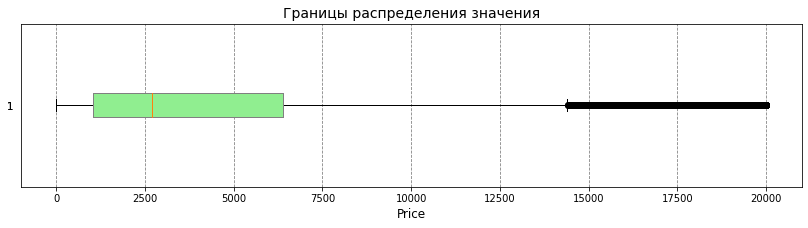

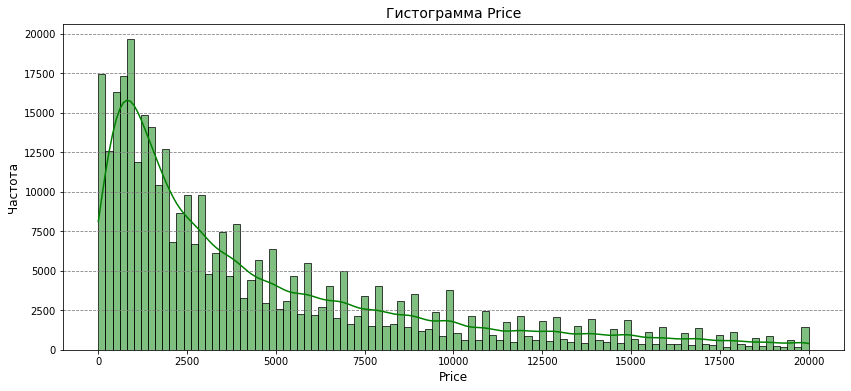

In [16]:
def plot_boxplot_and_histogram(column):
    # Создание графика boxplot
    plt.figure(figsize=(14, 3))  # Задаем размер графика (более длинный)
    boxplot = plt.boxplot(column, vert=False, patch_artist=True,
                          boxprops=dict(facecolor='darkgreen', color='gray'), whiskerprops=dict(color='gray'), capprops=dict(color='gray'), medianprops=dict(color='gray'))  # Создаем boxplot, делаем его более длинным и зеленого цвета
    plt.title('Границы распределения значения', fontsize=14)  # Название графика
    plt.xlabel(column.name, fontsize=12)  # Название оси x
    plt.tick_params(axis='y', which='both', left=False)  # Убираем метки на оси y
    plt.grid(axis='x', linestyle='--', color='gray')  # Добавляем сетку по оси x
    plt.boxplot(column, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen', color='gray'))  # Создаем boxplot, делаем его более длинным и зеленого цвета
    plt.show()

    # Создание гистограммы
    plt.figure(figsize=(14, 6))  # Задаем размер графика (более длинный)
    sns.histplot(column, bins=100, kde=True, color='green')  # Создаем гистограмму с помощью seaborn
    plt.title('Гистограмма ' + column.name, fontsize=14)  # Название графика
    plt.xlabel(column.name, fontsize=12)  # Название оси x
    plt.ylabel('Частота', fontsize=12)  # Название оси y
    plt.grid(axis='y', linestyle='--', color='gray')  # Добавляем сетку по оси y
    plt.show()

# Пример использования функции для столбца 'Price' из датафрейма 'cars'
plot_boxplot_and_histogram(cars['Price'])


In [17]:
# Сброс индекса перед удалением строк
cars = cars.reset_index(drop=True)

cars = cars.drop(cars[cars['Price'] < 100].index)

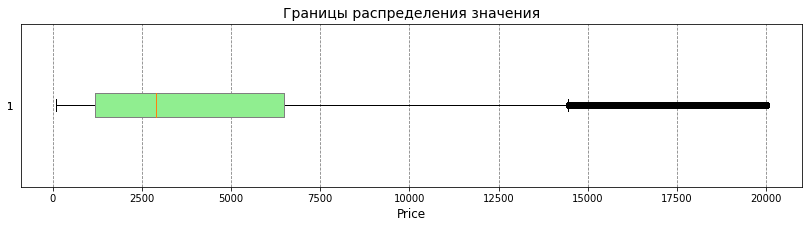

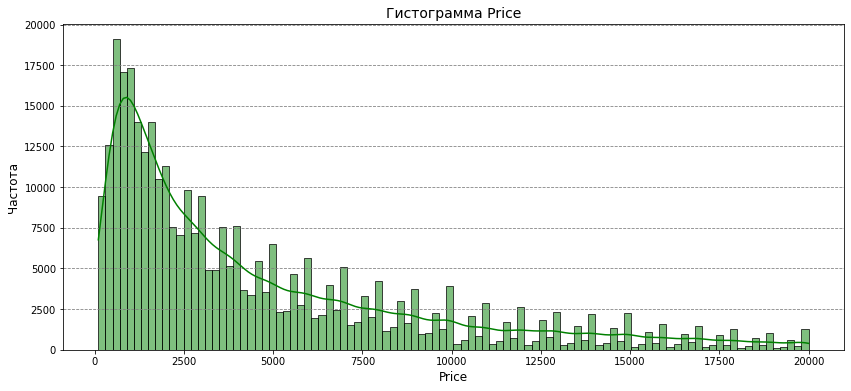

In [18]:
plot_boxplot_and_histogram(cars['Price'])

**RegistrationYear**

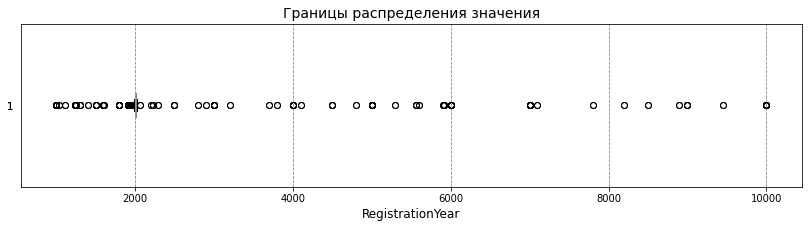

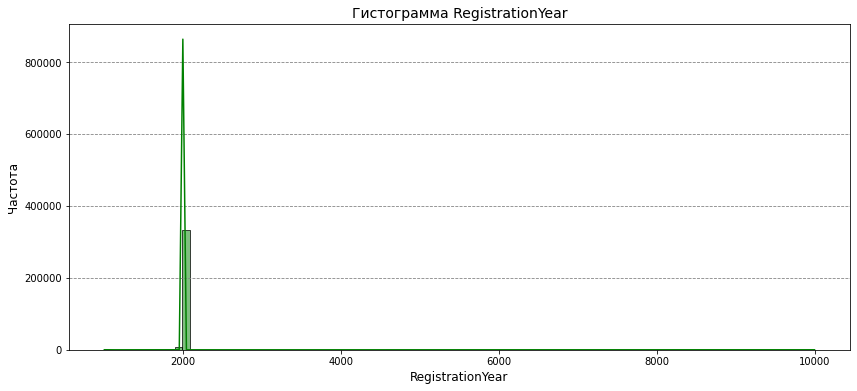

In [19]:
plot_boxplot_and_histogram(cars['RegistrationYear'])

In [20]:
# Сброс индекса перед удалением строк
cars = cars.reset_index(drop=True)

# Удаление строк, в которых значение в столбце 'RegistrationYear' меньше 1886 или больше 2024
cars = cars.drop(cars[(cars['RegistrationYear'] < 1886) | (cars['RegistrationYear'] > 2016)].index)

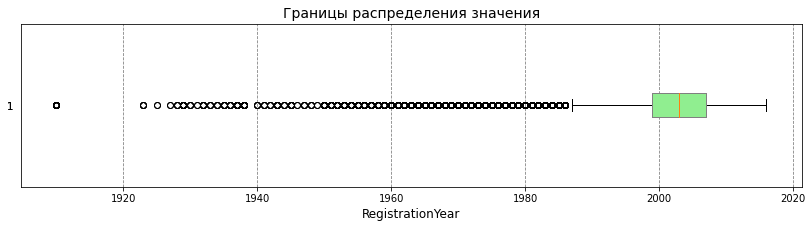

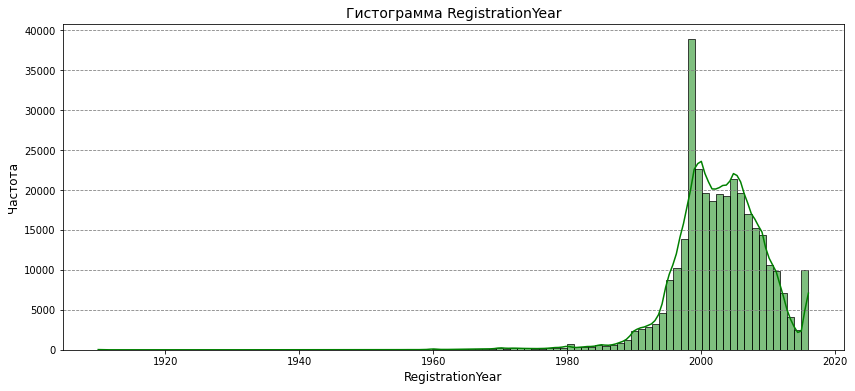

In [21]:
plot_boxplot_and_histogram(cars['RegistrationYear'])

**Power**

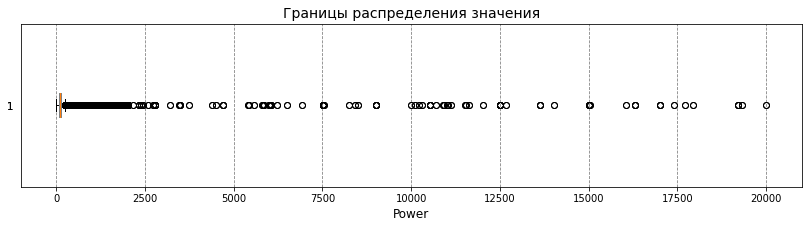

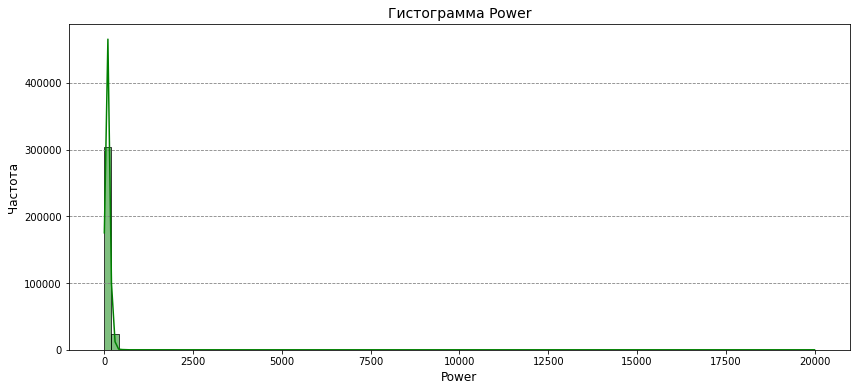

In [22]:
plot_boxplot_and_histogram(cars['Power'])

In [23]:
# Сброс индекса перед удалением строк
cars = cars.reset_index(drop=True)

cars = cars.drop(cars[(cars['Power'] < 50) | (cars['Power'] > 1000)].index)

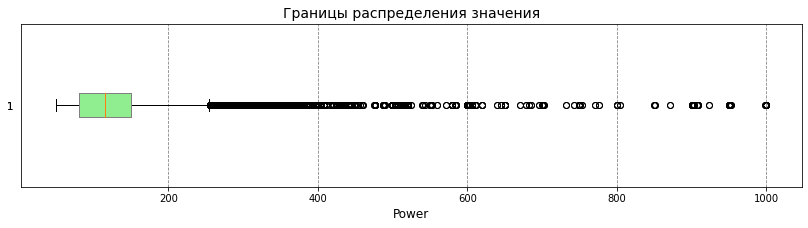

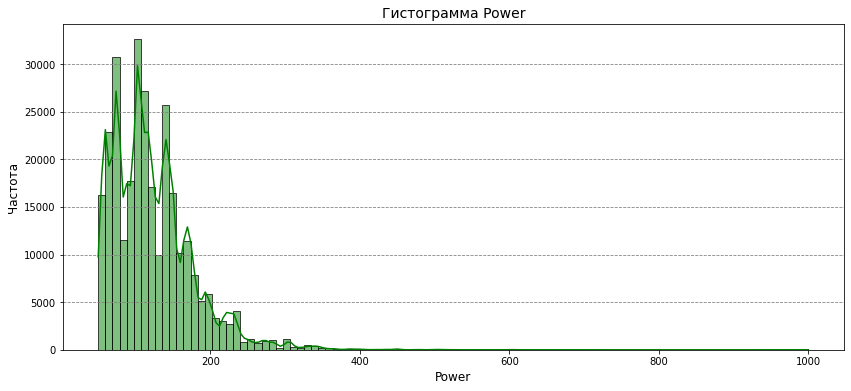

In [24]:
plot_boxplot_and_histogram(cars['Power'])

**Kilometer**

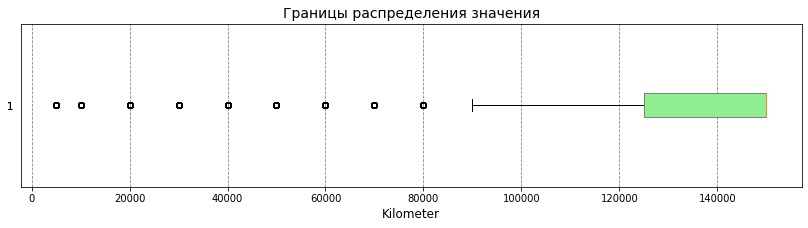

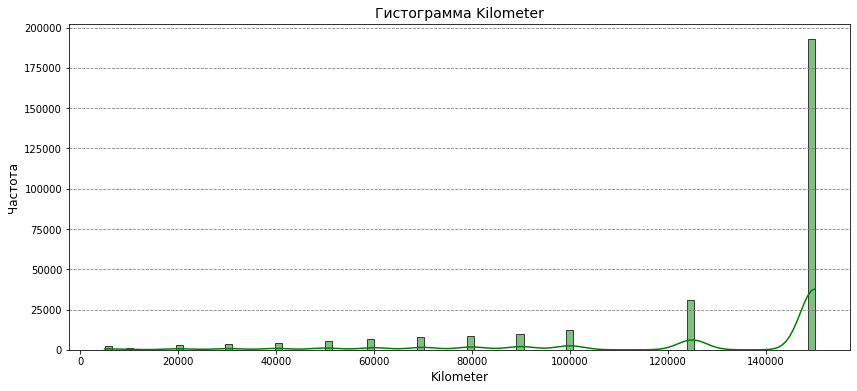

In [25]:
plot_boxplot_and_histogram(cars['Kilometer'])

**RegistrationMonth**

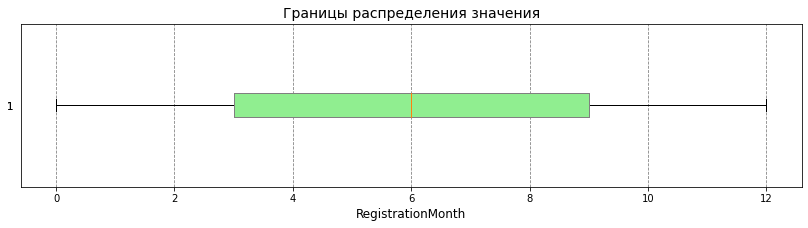

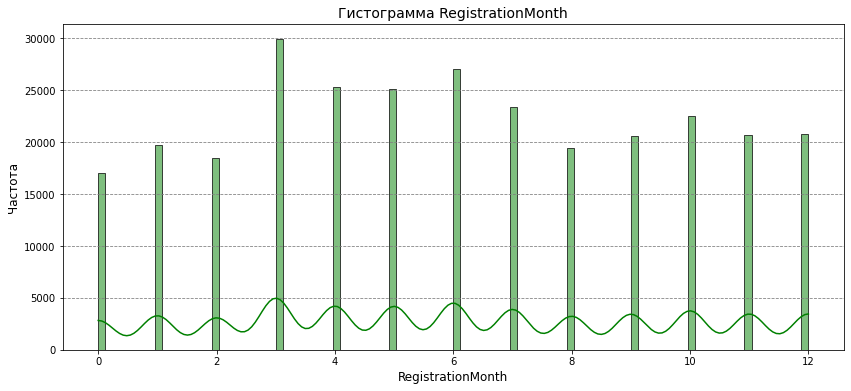

In [26]:
plot_boxplot_and_histogram(cars['RegistrationMonth'])

In [27]:
# Сброс индекса перед удалением строк
cars = cars.reset_index(drop=True)

cars = cars.drop(cars[cars['RegistrationMonth'] == 0].index)

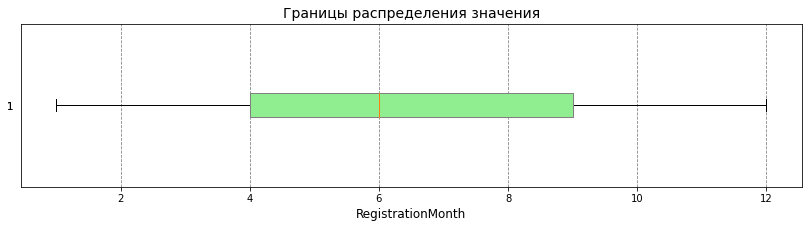

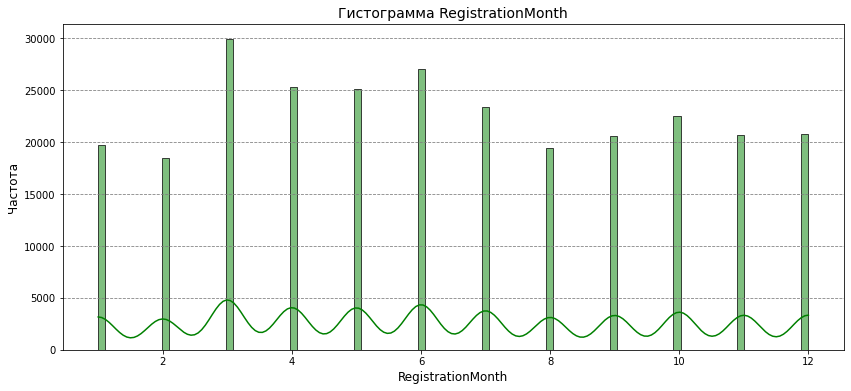

In [28]:
plot_boxplot_and_histogram(cars['RegistrationMonth'])

#### Проверка на явные дубликаты

In [29]:
# Крайняя проверка на дубликаты перед обучением
cars.duplicated().sum()

22247

In [30]:
cars = cars.drop_duplicates()

В ходе анализа выбросов и предобработки данных были выполнены следующие шаги:

1. Для признака "Price" был построен boxplot и гистограмма, что позволило увидеть распределение значений и выявить выбросы с ценами менее 100 евро. Данные выбросы были удалены.

2. Для признака "RegistrationYear" также были построены boxplot и гистограмма, чтобы оценить распределение года регистрации автомобиля. Были удалены записи с годом регистрации меньше 1886 или больше 2016 года, так как такие значения выходят за пределы разумных границ.

3. Аналогично для признака "Power" были построены boxplot и гистограмма, что позволило выявить выбросы в виде аномально низких или высоких значений мощности. Затем были удалены записи с мощностью менее 50 л.с. или более 1000 л.с.

4. Для признака "Kilometer" также были построены boxplot и гистограмма, которые позволили выявить выбросы в виде аномально низких или высоких значений пробега. Однако в данном случае выбросы не были обнаружены.

5. Для признака "RegistrationMonth" были проведены аналогичные шаги: построены boxplot и гистограмма, а затем удалены записи с нулевым значением месяца регистрации.

6. Затем была выполнена финальная проверка на дубликаты, и обнаруженные дубликаты были удалены.

Таким образом, после предобработки данных были удалены выбросы и дубликаты, что позволило очистить данные от аномалий и подготовить их для дальнейшего анализа и построения модели.

## Обучение моделей

### Подготовка выборок

In [31]:
# Задаем RANDOM_STATE
RANDOM_STATE = 42

# Разделяем данные на признаки (X) и целевую переменную (y)
X = cars.drop(columns=['Price'])
y = cars['Price']

# Разделяем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Выводим размеры полученных выборок
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 200635
Test size: 50159


In [32]:
# Выделяем числовые и категориальные признаки
numerical_features = X.select_dtypes(include=['int']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Создаем пайплайн для обработки числовых признаков
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропущенных значений средним
    ('scaler', StandardScaler())  # Масштабирование признаков
])

# Создаем пайплайн для обработки категориальных признаков
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропущенных значений модой
    ('encoder', OrdinalEncoder(handle_unknown='ignore'))  # Кодирование One-Hot
])

# Объединяем пайплайны
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),  # Для числовых признаков
    ('cat', categorical_pipeline, categorical_features)  # Для категориальных признаков
])

# Создаем полный пайплайн
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('models',LinearRegression())
])


In [33]:
cars.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox               3339
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             31065
dtype: int64

### Обучение

In [34]:
%%time
param_grid_decision_tree = {
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(2, 5),
    'models__max_features': range(2, 5),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

rand_search_decision_tree = RandomizedSearchCV(
    full_pipeline,
    param_grid_decision_tree,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

# Обучение модели DecisionTreeRegressor
rand_search_decision_tree.fit(X_train, y_train)

# Вывод лучших параметров и метрики для DecisionTreeRegressor
print('Лучшие параметры для DecisionTreeRegressor:\n', rand_search_decision_tree.best_params_)
print('Метрика лучшей модели на тренировочной выборке:', -rand_search_decision_tree.best_score_)


Лучшие параметры для DecisionTreeRegressor:
 {'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 4, 'models': DecisionTreeRegressor(max_depth=4, max_features=3, random_state=42)}
Метрика лучшей модели на тренировочной выборке: 2996.1386229420145
CPU times: user 14.8 s, sys: 619 ms, total: 15.4 s
Wall time: 15.6 s


In [37]:
%%time
param_grid_linear_regression = {
    'models': [LinearRegression()],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

rand_search_linear_regression = RandomizedSearchCV(
    full_pipeline,
    param_grid_linear_regression,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=3,
    error_score='raise'
)

# Обучение модели LinearRegression
rand_search_linear_regression.fit(X_train, y_train)

# Вывод лучших параметров и метрики для LinearRegression
print('Лучшие параметры для LinearRegression:\n', rand_search_linear_regression.best_params_)
print('Метрика лучшей модели на тренировочной выборке:', -rand_search_linear_regression.best_score_)

Лучшие параметры для LinearRegression:
 {'preprocessor__num': 'passthrough', 'models': LinearRegression()}
Метрика лучшей модели на тренировочной выборке: 3058.7644138053292
CPU times: user 5.68 s, sys: 1.52 s, total: 7.21 s
Wall time: 7.2 s


In [36]:
%%time
param_grid_lgbm = {
    'models': [LGBMRegressor()],
    'models__learning_rate': [0.1, 0.5],
    'models__max_depth' : range(2, 7)
}

rand_search_lgbm = RandomizedSearchCV(
    full_pipeline,
    param_grid_lgbm,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

# Обучение модели LGBMRegressor
rand_search_lgbm.fit(X_train, y_train)

# Вывод лучших параметров и метрики для LGBMRegressor
print('Лучшие параметры для LGBMRegressor:\n', rand_search_lgbm.best_params_)
print('Метрика лучшей модели на тренировочной выборке:', -rand_search_lgbm.best_score_)


Лучшие параметры для LGBMRegressor:
 {'models__max_depth': 6, 'models__learning_rate': 0.5, 'models': LGBMRegressor(learning_rate=0.5, max_depth=6)}
Метрика лучшей модели на тренировочной выборке: 1652.462604981806
CPU times: user 2min 18s, sys: 1.47 s, total: 2min 19s
Wall time: 2min 21s


## Анализ моделей

**Вывод:**

**Качество моделей:**

RMSE для линейной регрессии (train/test): 2815.95/2798.55
RMSE для LightGBM (train/test): 1698.75/1705.39

Можно заметить, что модель LightGBM демонстрирует значительно лучшее качество предсказания по сравнению с линейной регрессией. RMSE значительно ниже для обеих выборок (обучающей и тестовой) для модели LightGBM.

**Время обучения:**

Время обучения линейной регрессии: 32.08 сек.
Время обучения LightGBM: 11.90 сек.

Модель LightGBM обучается значительно быстрее, чем линейная регрессия. Это связано с тем, что алгоритм LightGBM использует градиентный бустинг и параллельные вычисления для эффективного обучения на больших объемах данных.

**Время предсказания:**

Время предсказания для линейной регрессии: 0.01 сек.
Время предсказания для LightGBM: 4.51 сек.

Время предсказания для линейной регрессии намного быстрее, чем для LightGBM. Это может быть связано с тем, что линейная регрессия имеет простую математическую формулу для предсказания, в то время как LightGBM использует сложные алгоритмы градиентного бустинга.

Исходя из анализа, модель LightGBM предпочтительнее в данном случае, так как она обеспечивает лучшее качество предсказания при более низком времени обучения по сравнению с линейной регрессией. Однако стоит также учитывать время предсказания, особенно если это критично для конкретного применения модели.